
[source](https://github.com/fastai/course22p2/blob/master/nbs/01_matmul.ipynb)



In [ ]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt


MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [ ]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [ ]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Dec 20 10:04 mnist.pkl.gz


In [ ]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [ ]:
im = list(x_train[0])
# below can be done by reshape(28,28) using numpy
a = []
for i in range(0,len(im),28):
  a.append(im[i:i+28])


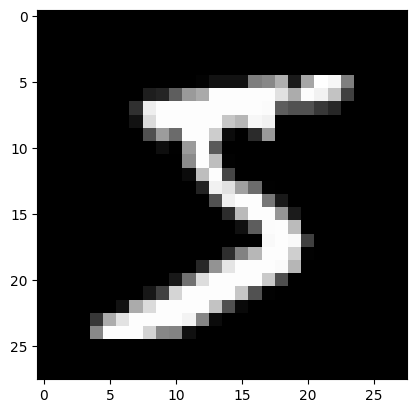

In [ ]:
plt.imshow(a, cmap='gray')

In [ ]:
# another cool way of doing the above operation
from itertools import islice
lst1 = list(range(30))
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 3)), []))

### Mean shift clustering

In [ ]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [ ]:
n_clusters=6
n_samples =250
centroids = torch.rand(6, 2)*70-35

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [ ]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))
slices = [sample(c) for c in centroids]

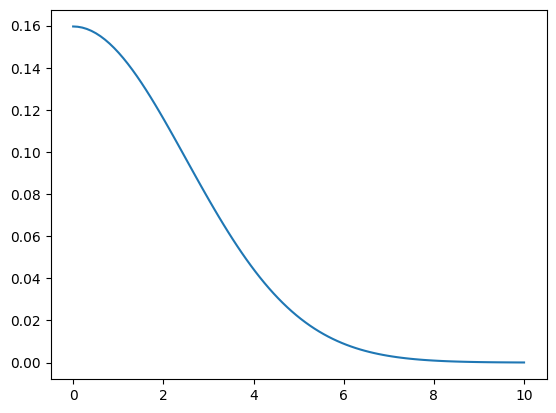

In [ ]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

plot_func(partial(gaussian, bw=2.5))

In [ ]:
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [ ]:
X = data.clone()
x = X[0]
x

tensor([26.204, 26.349])

In [ ]:
dist = ((x-X)**2).sum(1).sqrt()
dist

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [ ]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [ ]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [ ]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
        # weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()


def meanshift(data):
    X = data.clone()
    for it in range(15): one_update(X)
    return X

In [ ]:
X=meanshift(data)

In [ ]:
X

tensor([[26.792, 29.120],
        [26.792, 29.120],
        [26.792, 29.120],
        ...,
        [30.433,  6.471],
        [30.433,  6.471],
        [30.433,  6.471]])

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)


# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## Gpu batched algorithm

In [ ]:
a = torch.randint(1,10,(3,2))
b = torch.randint(1,10,(5,2))

In [ ]:
a[None].shape

torch.Size([1, 3, 2])

In [ ]:
b[:,None].shape

torch.Size([5, 1, 2])

In [ ]:
a = torch.randint(1,20,(5,1))
a, a.shape

(tensor([[ 8],
         [11],
         [ 9],
         [18],
         [18]]),
 torch.Size([5, 1]))

In [ ]:
b = torch.tensor([1, 2, 3, 4, 5], dtype=int)
b = b.view(-1,1)
b, b.shape

(tensor([[1],
         [2],
         [3],
         [4],
         [5]]),
 torch.Size([5, 1]))

In [ ]:
a+b

tensor([[ 9],
        [13],
        [12],
        [22],
        [23]])